# Initializing

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import comet_ml
import os
import torch
from torch.utils.data import DataLoader
from pathlib import Path

from src.utils.coco import COCODataset
from src.utils.pretty_print import *
from src.models import get_model_unet
from src.utils.train import unet_training_testing_loop
from src.utils.comet import CometLogger
from dotenv import load_dotenv

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 42

# for reproducibility
torch.manual_seed(SEED)

# Datasets

## COCO Datasets

In [4]:
slide_path = Path("/storage01/bolma/dev/data/datasets/WSI-ROI/slides/l8/annotations.json")

In [5]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(0.5),
    A.VerticalFlip(0.5),
    A.ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))


In [6]:
train_dataset = COCODataset(
    annotation_file=slide_path,
    train=True,
    transform=None,
    random_seed=SEED,
    bbox_format='pascal_voc'
)

test_dataset = COCODataset(
    annotation_file=slide_path,
    train=False,
    transform=None,
    random_seed=SEED,
    bbox_format='pascal_voc'
)

# Checks
train_images = set(id for id in train_dataset.image_ids)
test_images = set(id for id in test_dataset.image_ids)

print(f"Training image id-s: \t{train_images}")
print(f"\nTest image id-s: \t{test_images}")

# Overlapping images between datasets
overlapping_images = train_images.intersection(test_images)

if overlapping_images:
    print("\n[WARNING]: Overlapping images found:")
    for img in overlapping_images:
        print(f"- {img}")
else:
    print_success("Datasets are properly split and ready to use!")



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

✅ Loaded training set with 41 images

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

✅ Loaded test set with 11 images

Training image id-s: 	{0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 44, 45, 46, 48, 49, 51}

Test image id-s: 	{32, 3, 5, 41, 43, 12, 13, 47, 17, 50, 19}

✅ Datasets are properly split and ready to use!


### Visualization

Training Dataset Examples:
Image index: 18 (Image ID: 46)


/storage01/bolma/dev/tumor-region-detection-thesis/src/utils/coco.py:131: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  "masks": torch.as_tensor(masks, dtype=torch.uint8)


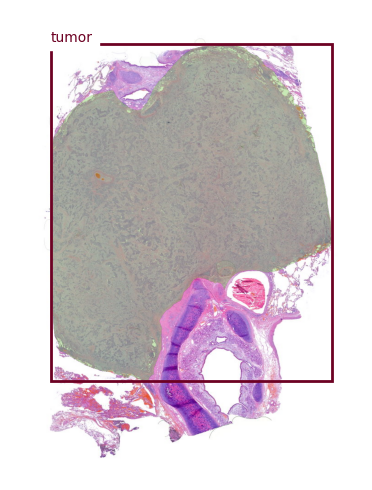

Image index: 20 (Image ID: 31)


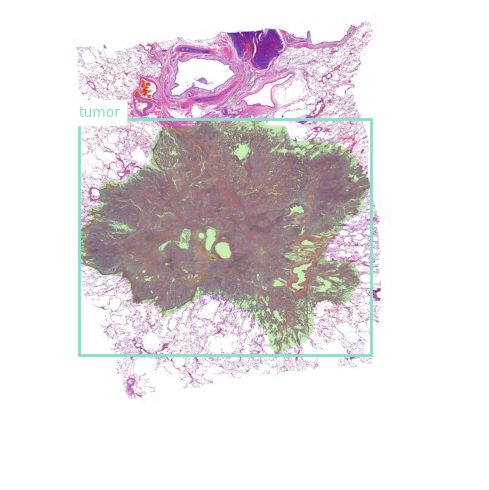

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from matplotlib.patches import Rectangle

def visualize_coco_samples(dataset, num_samples=3, indices=None, figsize=(15, 5), 
                          show_masks=True, show_boxes=True, show_labels=True,
                          mask_alpha=0.3, random_color=True):
    """
    Visualizes samples from COCO dataset with annotations.
    """
    if indices is None:
        # Get random indices
        indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for idx in indices:
        print(f"Image index: {idx} (Image ID: {dataset.image_ids[idx]})")
        image, target = dataset[idx]
        
        # If image is a tensor, convert to numpy array for visualization
        if isinstance(image, torch.Tensor):
            img = image.cpu().numpy().transpose(1, 2, 0)
            # Use consistent scaling - divide by 255 instead of min-max normalization
            img = img / 255.0
            # Clip to valid range
            img = np.clip(img, 0, 1)
        else:
            img = np.array(image) / 255.0
        
        # Create figure and axes
        fig, ax = plt.subplots(figsize=figsize)
        
        # Display image
        ax.imshow(img)
        
        # Get masks, boxes, and labels from target
        masks = target['masks']
        boxes = target['boxes']
        labels = target['labels']
        
        # Create a single combined overlay for all masks
        if show_masks and len(masks) > 0:
            # Initialize combined overlay
            h, w = masks[0].shape if len(masks) > 0 else img.shape[:2]
            combined_overlay = np.zeros((h, w, 4))  # RGBA image for overlay
            
            for i in range(len(masks)):
                if i < len(masks):
                    # Generate color for this instance
                    if random_color:
                        color = np.random.rand(3)
                    else:
                        cmap = plt.cm.get_cmap('tab10')
                        color = cmap(labels[i] % 10)[:3]
                    
                    # Add this mask to the combined overlay
                    mask = masks[i].cpu().numpy()
                    combined_overlay[mask == 1, :3] = color
                    combined_overlay[mask == 1, 3] = mask_alpha  # Set alpha channel
            
            # Apply the combined overlay
            ax.imshow(combined_overlay)
        
        # Display bounding boxes and labels
        for i in range(len(boxes)):
            # Generate color for this instance
            if random_color:
                color = np.random.rand(3)
            else:
                cmap = plt.cm.get_cmap('tab10')
                color = cmap(labels[i] % 10)[:3]
            
            # Display bounding box if requested
            if show_boxes and i < len(boxes):
                box = boxes[i].cpu().numpy()
                x1, y1, x2, y2 = box
                width = x2 - x1
                height = y2 - y1
                rect = Rectangle((x1, y1), width, height, 
                                linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                
                # Display category label if requested
                if show_labels:
                    category_id = labels[i].item()
                    category_name = dataset.categories.get(category_id, str(category_id))
                    ax.text(x1, y1-5, category_name, color=color, 
                           fontsize=10, backgroundcolor='white')
        
        ax.axis('off')
        plt.tight_layout()
        plt.show()

print("Training Dataset Examples:")
visualize_coco_samples(train_dataset, num_samples=2)

## Dataloaders

In [8]:
BATCH_SIZE = 1
NUM_WORKERS = 8

In [9]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    #collate_fn=lambda x: tuple(zip(*x))  # To handle variable size images/masks
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    #collate_fn=lambda x: tuple(zip(*x))
)

print_info(f"Created DataLoaders with batch size {BATCH_SIZE}")
print(f"\t- Training batches: {len(train_dataloader)}")
print(f"\t- Test batches: {len(test_dataloader)}")


ℹ️ Created DataLoaders with batch size 1
	- Training batches: 41
	- Test batches: 11


# Training

## Model architecture

In [10]:
unet = get_model_unet(in_channels=3,
                          out_channels=1,
                          features=[32, 64, 128, 256])

optimizer = torch.optim.SGD(unet.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)

## Training loop

In [16]:
import warnings

# For logging to comet.ml, a cloud service
load_dotenv()
api_key = os.getenv('COMET_API_KEY')
comet_logger = CometLogger(api_key=api_key,
                        project_name="msc-thesis",
                        experiment_name="UNet",
                        log_env_details=False,)

# Supressing some warning coming from a library with legacy code
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Creating a tensor from a list of numpy.ndarrays is extremely slow.')
    # Training loop
    unet_training_testing_loop(unet, device, train_dataloader, test_dataloader, optimizer, scheduler, n_epochs=30, comet_logger=comet_logger)

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml CometLogger Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : UNet
COMET INFO:     url                   : https://www.comet.com/bolf-marton/msc-thesis/28ea094dc98048b68a037cbc1b35c688
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     iou           : 0.6249681196429513
COMET INFO:     learning_rate : 0.001
COMET INFO:     loss [8]      : (0.6331820487976074, 0.7174892425537109)
COMET INFO:     test_loss     : 0.669534526088021
COMET INFO:     training_loss : 0.66693115234375
COMET INFO:   Others:
COMET INFO:     Name : UNet
COMET INFO:   Uploads:
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (1.14 MB)
COMET INFO:  


🚀 STARTING TRAINING
-----------------
Epoch 1/30 - UNet
-----------------


100%|██████████| 41/41 [00:04<00:00,  9.98it/s]


Train – Mean Loss: 0.6667


100%|██████████| 11/11 [00:01<00:00,  9.25it/s]


Test – IoU: 0.6406, Loss: 0.6706
-----------------
Epoch 2/30 - UNet
-----------------


 29%|██▉       | 12/41 [00:02<00:05,  4.95it/s]


KeyboardInterrupt: 

In [17]:
comet_logger.end() # End the comet logger session

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml CometLogger Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : UNet
COMET INFO:     url                   : https://www.comet.com/bolf-marton/msc-thesis/f9e439d8fd8d4ea997ba89e216421a3f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     iou           : 0.6406446912071921
COMET INFO:     learning_rate : 0.001
COMET INFO:     loss [6]      : (0.5862014293670654, 0.6888440847396851)
COMET INFO:     test_loss     : 0.6706319722262296
COMET INFO:     training_loss : 0.6667147874832153
COMET INFO:   Others:
COMET INFO:     Name : UNet
COMET INFO:   Uploads:
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (1.14 MB)
COMET INFO

In [13]:
# Save the model weights
torch.save(unet.state_dict(), "src/models/weights/UNet_trained_weights.pth")